In [1]:
import numpy as np 
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

# Custom metric is implemented here
from scorer import scorer
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="Example Desc")

##### Dropping users who viewed less than 3 items during at least one of the train, test and validation sets:

In [304]:
dtypes = {'id1': np.int16, 'id2': np.int16, 'id3': np.int16, 'user_id': np.int32, 'date': np.int16}
orig_data = pd.read_csv('train.csv', dtype=dtypes)
tr = orig_data.copy()

validation_start = tr.date.max() - 7
test_start = validation_start - 7
validation = tr[tr.date > validation_start]
test = tr[(tr.date > test_start) & (tr.date <= validation_start)]
train = tr[tr.date <= test_start - 14] 
last3w = tr[(tr.date > test_start - 21) & (tr.date <= test_start)]

# let's drop users who have no views during at least one of the periods:
user_entries_train = train.groupby('user_id').count()
user_entries_test = test.groupby('user_id').count()
user_entries_val = validation.groupby('user_id').count()
users_to_stay = [x for x in user_entries_train.index if (x in user_entries_test.index) & (x in user_entries_val.index)]

# let's also drop those who viewed less than 3 items during at least one of the 3 periods of time (train, test, val)
user_entries_train = train.groupby('user_id').count()
user_entries_test = test.groupby('user_id').count()
user_entries_val = validation.groupby('user_id').count()
users_to_drop = [[x for x in user_entries_train[user_entries_train.id3 < 3].index]]
users_to_drop.append([x for x in user_entries_test[user_entries_test.id3 < 3].index])
users_to_drop.append([x for x in user_entries_val[user_entries_val.id3 < 3].index])
users_to_drop = np.unique([x for sublist in users_to_drop for x in sublist])

tr = tr[~tr.user_id.isin(users_to_drop)]
tr = tr[tr.user_id.isin(users_to_stay)]
tr = tr.reset_index(drop = True)

#####  Sizes of different id1s:

In [388]:
# "id1": id1 labels
# "id2": no. of id2 subcategories in the corresponding id1
# "id3": no. of id3 subcategories in the corresponding id1 
# (ex: for the 2nd row id1 = 2, there are 5 id2 subcategories and 56 id3 subcategories in the 2nd category)

orig_gr = orig_data.groupby(['id1', 'id2', 'id3']).count()

cat_sizes = pd.DataFrame()
id1_ = np.unique(orig_data.id1)
id2_ = []
id3_ = []
for id_ in id1_:
    id2_.append(len(np.unique(orig_gr.loc[id_].index.labels[0])))
    id3_.append(len(np.unique(orig_gr.loc[id_].index.labels[1])))
cat_sizes['id1'] = id1_
cat_sizes['id2'] = id2_
cat_sizes['id3'] = id3_

cat_sizes.head()

,id1,id2,id3
0,0,1,11
1,1,14,82
2,2,5,56
3,3,8,44
4,4,13,79


##### Shares of id1s viewed by each user:

In [387]:
# ex: user #13 viewed only id1 == 9, user #9 viewed id1 == 10 in 54.3% of times

id1_table = tr.groupby(by = ['user_id', 'id1']).count()['id2'].unstack(1).fillna(0)
id1_mat = np.matrix(id1_table)
rowsums = np.array(id1_table.sum(axis = 1))
id1_share_table = id1_mat / rowsums[:,None]
id1_share_table_pd = pd.DataFrame(id1_share_table, columns=id1_table.columns, index=id1_table.index).round(3)

id1_share_table_pd['max_share'] = id1_share_table_pd.max(axis = 1)
id1_share_table_pd['max_share_id1'] = id1_share_table_pd.apply(np.argmax, axis=1)

# 0-15: shares of id1s viewed by each user; max_share, max_share_id1: max share among 0-15 and the corresponding id1 
id1_share_table_pd.head()

id1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,max_share,max_share_id1
user_id,,,,,,,,,,,,,,,,,,
9,0.000,0.000,0.000,0.000,0.086,0.000,0.000,0.000,0.143,0.000,0.543,0.000,0.143,0.000,0.000,0.086,0.543,10
13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,9
18,0.000,0.000,0.000,0.000,0.047,0.000,0.070,0.209,0.081,0.360,0.105,0.023,0.023,0.023,0.035,0.023,0.360,9
27,0.004,0.013,0.074,0.052,0.057,0.022,0.078,0.026,0.100,0.061,0.330,0.009,0.070,0.013,0.057,0.035,0.330,10
29,0.000,0.000,0.000,0.000,0.912,0.000,0.000,0.029,0.029,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.912,4


#####  id1 coverage for all id1s for all users 

In [380]:
# among users who had a favourite id1 (whose share of views of this id1 was the highest) we can distinguish
# those who viewed mostly one id3 and those who viewed many id3s in this id1. "Id1 coverage" accounts for 
# the share of id3s in id1 that this user has seen at least once. Ex: if he viewed 4 items in a category with 10
# items, his coverage of this category is 25%.

wtab = tr.groupby(by = ['user_id', 'id1', 'id3']).count()['id2'].unstack(1).fillna(0)

category_coverages = []
category_sizes = np.array(cat_sizes['id3'])
for user in tqdm(wtab.index.levels[0]):
    category_coverages.append(np.count_nonzero(np.array(wtab.loc[user]), 0) / category_sizes)

100%|██████████| 125021/125021 [01:02<00:00, 1986.54it/s]


In [385]:
id1_coverages = pd.DataFrame(np.array(category_coverages)).round(2)
id1_coverages.columns = ['cov_'+str(x) for x in range(0,16)]
id1_coverages.index = wtab.index.levels[0]
ltab = id1_coverages.join(id1_share_table_pd)

main_id1_coverage_1 = []
for user in tqdm(ltab.index):
    main_id1_coverage_1.append(ltab.loc[user]['cov_'+str(ltab['max_share_id1'].loc[user])])

100%|██████████| 125021/125021 [00:34<00:00, 3650.64it/s]


In [386]:
# cov_0 to cov_15: coverages of categories 0-15; 0-15: share of views of this category from total;
# most_viewed_id1s: like max_share but with 2nd most viewed id1 as well; 
ltab['main_id1_cvrg'] = main_id1_coverage_1

# main_id1_well_covered: categories from most_viewed_id1s with coverage > 7%

ltab.head()

,cov_0,cov_1,cov_2,cov_3,cov_4,cov_5,cov_6,cov_7,cov_8,cov_9,...,9,10,11,12,13,14,15,max_share,max_share_id1,main_id1_cvrg
user_id,,,,,,,,,,,,,,,,,,,,,
9,0.00,0.00,0.00,0.0,0.03,0.00,0.00,0.00,0.09,0.00,...,0.000,0.543,0.000,0.143,0.000,0.000,0.086,0.543,10,0.13
13,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.02,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,9,0.02
18,0.00,0.00,0.00,0.0,0.03,0.00,0.03,0.12,0.07,0.24,...,0.360,0.105,0.023,0.023,0.023,0.035,0.023,0.360,9,0.24
27,0.09,0.04,0.23,0.2,0.11,0.07,0.15,0.09,0.33,0.16,...,0.061,0.330,0.009,0.070,0.013,0.057,0.035,0.330,10,0.29
29,0.00,0.00,0.00,0.0,0.06,0.00,0.00,0.01,0.02,0.02,...,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.912,4,0.06


##### Shares of id3s viewed by each user:

In [389]:
id3_table = tr.groupby(by = ['user_id', 'id3']).count()['id2'].unstack(1).fillna(0)
id3_mat = np.matrix(id3_table)
rowsums = np.array(id3_table.sum(axis = 1))
id3_share_table = id3_mat / rowsums[:,None]
id3_share_table_pd = pd.DataFrame(id3_share_table, columns=id3_table.columns, index=id3_table.index).round(3)

id3_share_table_pd.head()

id3,0,1,2,3,4,5,6,7,8,9,...,921,922,923,924,925,926,927,928,929,930
user_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Predictions

In [12]:
def calculate_target(data, date_test_start):
    '''
        This function returns a dictionary of type {user: items_list}
        Such that user viewed an item in testing period, 
        but did not view it within the last 3 weeks of train period.
    '''
    
    test_mask = (data.date >= date_test_start) & (data.date < date_test_start + 7)
    last_3weeks_mask = (data.date >= date_test_start - 21 + 1) & (data.date < date_test_start)
    
    # Items that used viewed during test period
    items_test = data[test_mask].groupby('user_id').id3.apply(set)
    
    # Items, that user viewd in last 3 weeks
    user_last_3weeks = data[last_3weeks_mask].groupby('user_id').id3.apply(set)
    
    # Get table, where for each `user_id` we have both items from test period and 3 weeks
    joined = items_test.reset_index().merge(user_last_3weeks.reset_index(), on=['user_id'], how='left')
    joined.set_index('user_id', inplace=True)
    
    # Remove the items, which the user viewed during last 3 weeks 
    target = {}
    for user_id, (id3_x, id3_y) in joined.iterrows():   
        items = id3_x if id3_y is np.nan else id3_x - id3_y
        if items != set(): target.update({user_id: items})

    return target

def get_feats(data):
    '''
        Builds sparse matrix using users' history.
    '''
    return scipy.sparse.coo_matrix(([1] * data.shape[0], (data.user_id, data.id3)), 
                                    shape =[data.user_id.max()+1, data.id3.max()+1]).tocsr()
def get_target_matrix(X, target_dict):
    '''
        Builds sparse matrix using dictionary.
    '''
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    ks = []
    for k in tqdm(range(X.user_id.max()+1)):
        d = target_dict.get(k, [])
        for y in d:
            indices.append(y)
            data.append(1)
        indptr.append(len(indices))
    return scipy.sparse.csr_matrix((data, indices, indptr), dtype=int, shape =[X.user_id.max()+1, X.id3.max()+1])

In [14]:
# Unique pairs of id1s and id3s
id3s_ = tr.drop_duplicates(subset = ['id1', 'id3'])[['id1', 'id3']].sort_values(by  = 'id1')

,id1,id3
2587,0,670
8917,0,720
8587,0,101
8205,0,277
21123,0,486


# Log Reg (score: 1950)
----
### отбирались и для обучения, и для предсказания юзеры, у которых хотя бы 30% просмотров принадлежат к одной и той же категории id1, при этом в этой id1 просмотрено хотя бы 2% id3 (почти во всех id1 больше 50-и id3, то есть это страховка от юзеров, которые смотрели только 1 товар из этой категории)

In [16]:
train = tr.copy()
date_validation_start = train.date.max() - 6
y_val_dict = calculate_target(train, date_validation_start) 
userids = [x for x in ltab[(ltab.max_share > 0.3) & (ltab.main_id1_cvrg > 0.02)].index if x in train.user_id] #approx. 70k users
mask_for_all = train.user_id.isin(userids)
train = train.loc[mask_for_all]

mask_train = train.date < date_validation_start - 7
mask_test = (train.date < date_validation_start) & (train.date >= train.date.min() + 7)

# For the sake of speed select only 10k users to train on
users_mask = train.user_id.isin(np.random.choice(userids, 120000))
mask_train = mask_train & users_mask
mask_test = mask_test

# For each user count how many items he viewed
X_train = get_feats(train.loc[mask_train])
X_test = get_feats(train.loc[mask_test])

y_train_dict = calculate_target(train.loc[users_mask], date_validation_start - 7)
y_train = get_target_matrix(train.loc[mask_train], y_train_dict)
y_test = get_target_matrix(train.loc[mask_test], y_val_dict)

100%|██████████| 1179540/1179540 [00:01<00:00, 995748.66it/s]


In [19]:
def fit(i):
    target = y_train[:, i].toarray().ravel()
    
    if target.mean() == 0:
        return np.zeros((X_test.shape[0], )) - 1 
    
    d = LogisticRegression(max_iter=35)
    d.fit(X_train, target)
    return (d.predict_proba(X_test)[:, 1])

preds = Parallel(n_jobs = 8, verbose=20)(delayed(fit)(i) for i in range(y_train.shape[1]))
preds = np.vstack(preds).T

# To reduce memory usage
preds = preds.astype(np.float16)

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   26.9s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   27.4s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   28.5s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   59.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Do

In [98]:
num = 53979
users = train.loc[mask_test].user_id.value_counts().index[:num]
ans_inds =  np.argsort(preds[users])
num_users = len(train.user_id[train.date < date_validation_start].unique())

In [100]:
# For each user find the categories, which we do not want to predict
last_3weeks = train.loc[mask_test].loc[train.loc[mask_test].date >= train.loc[mask_test].date.max() - 21 + 1]
y_not = last_3weeks.groupby('user_id').id3.apply(set)

y_pred = {}

for u_idx, user in tqdm(enumerate(users)):
    items_not = y_not.get(user, [])
    items_pred = []
    i = 1
    while len(items_pred) < 5:
        if not ans_inds[u_idx, -i] in items_not:
            items_pred += [ans_inds[u_idx, -i]]
    
        i += 1
    y_pred.update({user: items_pred})
    
print(scorer(y_val_dict, y_pred, num_users))

53979it [00:03, 16015.50it/s]


AssertionError: Found predictions for 53979 users, instead of 3451.

In [24]:
y_pred_df = pd.DataFrame.from_records(y_pred).T.reset_index()
y_pred_df.columns = ['user_id', 'id3_1', 'id3_2', 'id3_3', 'id3_4', 'id3_5']
y_pred_df.to_csv('y_predictions_for_19k_users.csv', index=False)

!rm y_predictions_for_19k_users.csv.zip; zip y_predictions_for_19k_users.csv.zip y_predictions_for_19k_users.csv

  adding: y_predictions_for_19k_users.csv (deflated 64%)


##### Попробовала заменить в уже полученных предсказаниях самую маловероятную рекомендацию на самый часто просматриваемый этим юзером id3, если он не был им просмотрен за последние 3 недели, но результат ухудшился

In [29]:
id3_table = train.groupby(by = ['user_id', 'id3']).count()['id2'].unstack(1).fillna(0)
id3_mat = np.matrix(id3_table)
rowsums = np.array(id3_table.sum(axis = 1))
id3_share_table = id3_mat / rowsums[:,None]
id3_share_table_pd = pd.DataFrame(id3_share_table, columns=id3_table.columns, index=id3_table.index).round(3)

id3_share_table_pd.head(3)

id3,0,1,2,3,4,5,6,7,8,9,...,921,922,923,924,925,926,927,928,929,930
user_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
users = train.user_id.unique()
view_shares = id3_share_table_pd[id3_share_table_pd.index.isin(users)]
most_viewed_item = [view_shares.loc[x].argmax() for x in tqdm(users)]
view_shares['mvi'] = most_viewed_item

100%|██████████| 69006/69006 [00:17<00:00, 3979.36it/s]


In [73]:
y_not = last_3weeks.groupby('user_id').id3.apply(set)

y_pred_new = y_pred.copy()
for user in y_pred_new.keys():
    if view_shares.loc[user].mvi not in y_pred_new.get(user):
        if view_shares.loc[user].mvi not in y_not.get(user):
            y_pred_new.get(user)[-1] = view_shares.loc[user].mvi

In [89]:
y_pred_df = pd.DataFrame.from_records(y_pred_new).T.reset_index()
y_pred_df.columns = ['user_id', 'id3_1', 'id3_2', 'id3_3', 'id3_4', 'id3_5']
y_pred_df = y_pred_df.astype(int)
y_pred_df.to_csv('y_predictions_upd.csv', index=False)

1949 -> 1931

# XGBoost (score: 2014)
----
### отбирались и для обучения, и для предсказания юзеры, у которых хотя бы 35% просмотров принадлежат к одной и той же категории id1, при этом в этой id1 просмотрено хотя бы 1.5% id3 

In [107]:
train = tr.copy()
date_validation_start = train.date.max() - 6
y_val_dict = calculate_target(train, date_validation_start) 
userids = [x for x in ltab[(ltab.max_share > 0.35) & (ltab.main_id1_cvrg > 0.015)].index if x in train.user_id] #approx. 70k users
mask_for_all = train.user_id.isin(userids)
train = train.loc[mask_for_all]

mask_train = train.date < date_validation_start - 7
mask_test = (train.date < date_validation_start) & (train.date >= train.date.min() + 7)

# For the sake of speed select only 10k users to train on
users_mask = train.user_id.isin(np.random.choice(userids, 125000))
mask_train = mask_train & users_mask
mask_test = mask_test

# For each user count how many items he viewed
X_train = get_feats(train.loc[mask_train])
X_test = get_feats(train.loc[mask_test])

y_train_dict = calculate_target(train.loc[users_mask], date_validation_start - 7)
y_train = get_target_matrix(train.loc[mask_train], y_train_dict)
y_test = get_target_matrix(train.loc[mask_test], y_val_dict)

100%|██████████| 1179540/1179540 [00:01<00:00, 926268.01it/s]


In [112]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
def fit_xgb(i):
    target = y_train[:, i].toarray().ravel()
    
    if target.mean() == 0:
        return np.zeros((X_test.shape[0], )) - 1 
    xgb1 = XGBClassifier(max_depth = 3, n_estimators = 150)
    xgb1.fit(X_train, target, eval_metric='auc')     
    return (xgb1.predict_proba(X_test)[:, 1])

preds_xgb = Parallel(n_jobs = 4, verbose=20)(delayed(fit_xgb)(i) for i in range(y_train.shape[1]))
preds_xgb = np.vstack(preds_xgb).T
preds_xgb = preds_xgb.astype(np.float16)

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Do

In [299]:
num = 53979
users = train.loc[mask_test].user_id.value_counts().index[:num]
ans_inds =  np.argsort(preds_xgb[users])
num_users = len(train.user_id[train.date < date_validation_start].unique())

In [300]:
last_3weeks = train.loc[mask_test].loc[train.loc[mask_test].date >= train.loc[mask_test].date.max() - 21 + 1]
y_not = last_3weeks.groupby('user_id').id3.apply(set)

y_pred_xgb = {}

for u_idx, user in tqdm(enumerate(users)):
    items_not = y_not.get(user, [])
    items_pred = []
    i = 1
    while len(items_pred) < 5:
        if not ans_inds[u_idx, -i] in items_not:
            items_pred += [ans_inds[u_idx, -i]]
    
        i += 1
    y_pred_xgb.update({user: items_pred})
    
print(scorer(y_val_dict, y_pred_xgb, num_users))

53979it [00:02, 18844.25it/s]


AssertionError: Found predictions for 53979 users, instead of 3254.

In [116]:
y_pred_df = pd.DataFrame.from_records(y_pred_xgb).T.reset_index()
y_pred_df.columns = ['user_id', 'id3_1', 'id3_2', 'id3_3', 'id3_4', 'id3_5']
y_pred_df = y_pred_df.astype(int)
y_pred_df.to_csv('y_predictions_xgb.csv', index=False)

In [118]:
!rm y_predictions_xgb.csv.zip; zip y_predictions_xgb.csv.zip y_predictions_xgb.csv

rm: y_predictions_xgb.csv.zip: No such file or directory
  adding: y_predictions_xgb.csv (deflated 66%)


##### Demand for different items at different times

In [398]:
id3bydate = tr.groupby(['id3', 'date']).count()['id1'].unstack(1).fillna(0)
rowmean = np.array(id3bydate.mean(axis = 1))
id3bydate = id3bydate.drop(id3bydate.index[np.where(rowmean < 10)], 0)
rowmean = np.array(id3bydate.mean(axis = 1))
id3bydate = id3bydate.drop(id3bydate.index[np.where(rowmean > 10000)], 0)
id3bydate_mat = np.matrix(id3bydate)
rowsums = np.array(id3bydate.sum(axis = 1))
id3bydate_share_table = id3bydate_mat / rowsums[:,None]
id3bydate_share_table_pd = pd.DataFrame(id3bydate_share_table, columns=id3bydate.columns, index=id3bydate.index).round(3)

id3bydate_share_table_pd.head(3)

date,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
id3,,,,,,,,,,,,,,,,,,,,,
0,0.001,0.023,0.019,0.018,0.022,0.021,0.028,0.029,0.026,0.021,...,0.008,0.008,0.010,0.000,0.011,0.009,0.009,0.007,0.008,0.010
1,0.001,0.019,0.016,0.015,0.015,0.017,0.027,0.026,0.024,0.017,...,0.008,0.010,0.014,0.001,0.015,0.016,0.012,0.010,0.009,0.013
3,0.002,0.024,0.023,0.025,0.026,0.028,0.032,0.034,0.031,0.023,...,0.001,0.002,0.003,0.000,0.002,0.002,0.002,0.002,0.001,0.002


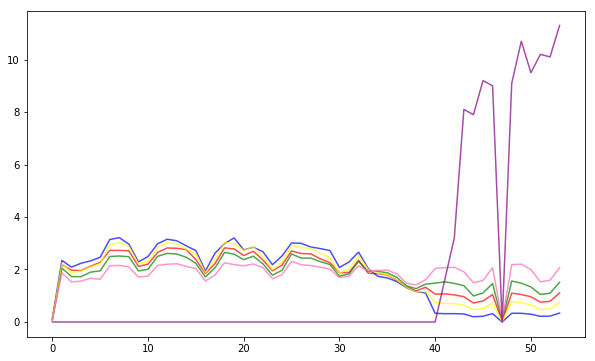

In [399]:
from sklearn.cluster import KMeans
n_clusters = 6

fig, ax = plt.subplots(figsize=(10,6))
colours = ['red', 'blue','green', 'yellow', 'hotpink', 'purple', 'black', 'cyan']
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(id3bydate_share_table_pd)
for k, colour in zip(kmeans.cluster_centers_, colours):
    plt.plot(100*k,color=colour,label=colour, alpha = .7)
#for k in kmeans.cluster_centers_:
 #   plt.plot(100*k)
clusters = kmeans.predict(id3bydate_share_table_pd)

In [400]:
id3bydate_share_table_pd['cluster'] = clusters
id3bydate_share_table_pd[id3bydate_share_table_pd.cluster.isin([1])].index

Int64Index([  3,   4,   8,   9,  16,  22,  24,  28,  42,  56,
            ...
            868, 879, 894, 899, 906, 909, 912, 915, 923, 928],
           dtype='int64', name='id3', length=160)

### Убираю из таргета товары, на которые был низкий спрос спрос в последние 2 недели (синий график)

In [401]:
train = tr.copy()
low_demand_items = id3bydate_share_table_pd[id3bydate_share_table_pd.cluster.isin([1])].index
mask_last_week = train.date >= date_validation_start - 7

date_validation_start = train.date.max() - 6
y_val_dict = calculate_target(train, date_validation_start) 
userids = [x for x in ltab[(ltab.max_share > 0.35) & (ltab.main_id1_cvrg > 0.015)].index if x in train.user_id] #approx. 70k users
mask_for_all = train.user_id.isin(userids)
train = train.loc[mask_for_all]
train = train.drop(train.loc[mask_last_week][train.loc[mask_last_week].id3.isin(low_demand_items)].index, 0)

mask_train = train.date < date_validation_start - 7
mask_test = (train.date < date_validation_start) & (train.date >= train.date.min() + 7)

# For the sake of speed select only 10k users to train on
users_mask = train.user_id.isin(np.random.choice(userids, 120000))
mask_train = mask_train & users_mask
mask_test = mask_test

# For each user count how many items he viewed
X_train = get_feats(train.loc[mask_train])
X_test = get_feats(train.loc[mask_test])

y_train_dict = calculate_target(train.loc[users_mask], date_validation_start - 7)
y_train = get_target_matrix(train.loc[mask_train], y_train_dict)
y_test = get_target_matrix(train.loc[mask_test], y_val_dict)

100%|██████████| 1179540/1179540 [00:01<00:00, 1014096.18it/s]


In [344]:
def fit(i):
    target = y_train[:, i].toarray().ravel()
    
    if target.mean() == 0:
        return np.zeros((X_test.shape[0], )) - 1 
    
    d = LogisticRegression(max_iter=55)
    d.fit(X_train, target)
    return (d.predict_proba(X_test)[:, 1])

preds_red = Parallel(n_jobs = 8, verbose=20)(delayed(fit)(i) for i in range(y_train.shape[1]))
preds_red = np.vstack(preds_red).T

# To reduce memory usage
preds_red = preds_red.astype(np.float16)

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1883s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:   23.4s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:   33.9s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:   54.2s
[Parallel(n_jobs=8)]: Batch computation too slow (53.8535s.) Setting batch_size=1.
[Parallel(n_jobs=8)]: Done  16 tasks      

In [345]:
num = 53979
users = train.loc[mask_test].user_id.value_counts().index[:num]
ans_inds =  np.argsort(preds_red[users])
num_users = len(train.user_id[train.date < date_validation_start].unique())

last_3weeks = train.loc[mask_test].loc[train.loc[mask_test].date >= train.loc[mask_test].date.max() - 21 + 1]
y_not = last_3weeks.groupby('user_id').id3.apply(set)

y_pred = {}

for u_idx, user in tqdm(enumerate(users)):
    items_not = y_not.get(user, [])
    items_pred = []
    i = 1
    while len(items_pred) < 5:
        if not ans_inds[u_idx, -i] in items_not:
            items_pred += [ans_inds[u_idx, -i]]
    
        i += 1
    y_pred.update({user: items_pred})
    
print(scorer(y_val_dict, y_pred, num_users))

53979it [00:02, 18384.75it/s]


AssertionError: Found predictions for 53979 users, instead of 3254.

In [346]:
y_pred_df = pd.DataFrame.from_records(y_pred).T.reset_index()
y_pred_df.columns = ['user_id', 'id3_1', 'id3_2', 'id3_3', 'id3_4', 'id3_5']
y_pred_df.to_csv('y_predictions_targetred.csv', index=False)

!rm y_predictions_targetred.csv.zip; zip y_predictions_targetred.csv.zip y_predictions_targetred.csv

rm: y_predictions_targetred.csv.zip: No such file or directory
  adding: y_predictions_targetred.csv (deflated 66%)


In [480]:
tr = pd.read_csv('train.csv', dtype=dtypes)
id3bydate = tr.groupby(['id3', 'date']).count()['id1'].unstack(1).fillna(0)
rowmean = np.array(id3bydate.mean(axis = 1))
id3bydate = id3bydate.drop(id3bydate.index[np.where(rowmean < 10)], 0)
rowmean = np.array(id3bydate.mean(axis = 1))
id3bydate = id3bydate.drop(id3bydate.index[np.where(rowmean > 10000)], 0)
id3bydate_mat = np.matrix(id3bydate)
rowsums = np.array(id3bydate.sum(axis = 1))
id3bydate_share_table = id3bydate_mat / rowsums[:,None]
id3bydate_share_table_pd = pd.DataFrame(id3bydate_share_table, columns=id3bydate.columns, index=id3bydate.index).round(3)

id3bydate_share_table_pd.head(3)

date,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
id3,,,,,,,,,,,,,,,,,,,,,
0,0.001,0.023,0.019,0.020,0.023,0.022,0.029,0.029,0.028,0.023,...,0.006,0.006,0.007,0.0,0.008,0.007,0.008,0.007,0.007,0.008
1,0.000,0.021,0.016,0.017,0.017,0.017,0.029,0.027,0.026,0.020,...,0.007,0.008,0.011,0.0,0.011,0.012,0.010,0.008,0.007,0.012
3,0.001,0.026,0.024,0.026,0.028,0.029,0.035,0.034,0.031,0.026,...,0.001,0.001,0.002,0.0,0.001,0.001,0.001,0.001,0.001,0.002


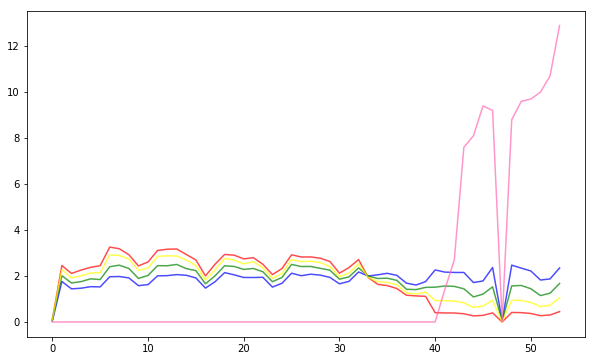

In [481]:
from sklearn.cluster import KMeans
n_clusters = 5

fig, ax = plt.subplots(figsize=(10,6))
colours = ['red', 'blue','green', 'yellow', 'hotpink', 'purple', 'black', 'cyan']
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(id3bydate_share_table_pd)
for k, colour in zip(kmeans.cluster_centers_, colours):
    plt.plot(100*k,color=colour,label=colour, alpha = .7)
#for k in kmeans.cluster_centers_:
 #   plt.plot(100*k)
clusters = kmeans.predict(id3bydate_share_table_pd)

##### Идея: взять уже существующие предсказания xgboost'а и взвесить их пропорционально спросу на них в последние 2 недели. То есть если алгоритм предсказал юзеру товар из красного кластера и товар из синего кластера с одинаковой predict_proba, благодаря весам товар из синего кластера будет приоритетнее, поскольку на него в целом спрос к последней неделе стал больше

In [560]:
id3bydate_share_table_pd['cluster'] = clusters
id3_clusters = pd.DataFrame(sorted(tr.id3.unique()))
id3_clusters.columns = ['id3']

clusters = id3_clusters.merge(pd.DataFrame(id3bydate_share_table_pd['cluster']).reset_index(), how = 'left', on = ['id3'])
clusters = clusters.fillna(999)

In [561]:
def replace_with_multiplier(x):
    if x == 0:
        z = 1
    elif x == 1:
        z = 1.4
    elif x == 2:
        z = 1.3
    elif x == 3:
        z = 1.1
    elif x == 4:
        z = 1.6
    else:
        z = 1.5
    return z

clusters['cluster'] = clusters['cluster'].apply(replace_with_multiplier)

In [562]:
nmbrs = []
for i in range(931):
    if i not in clusters.id3.values:
        nmbrs.append(i)
        
f1 = pd.DataFrame({'id3': nmbrs})
f1['cluster'] = np.repeat(1.0, 7)
clusters = clusters.append(f1, 0)
clusters = clusters.sort_values(by = 'id3', ascending=True).reset_index(drop = 1)
nu = newpredsxgb * clusters.cluster.values

In [554]:
train = tr.copy()
low_demand_items = id3bydate_share_table_pd[id3bydate_share_table_pd.cluster.isin([1])].index
mask_last_week = train.date >= date_validation_start - 7

date_validation_start = train.date.max() - 6
y_val_dict = calculate_target(train, date_validation_start) 
userids = [x for x in ltab[(ltab.max_share > 0.35) & (ltab.main_id1_cvrg > 0.015)].index if x in train.user_id] #approx. 70k users
mask_for_all = train.user_id.isin(userids)
train = train.loc[mask_for_all]
train = train.drop(train.loc[mask_last_week][train.loc[mask_last_week].id3.isin(low_demand_items)].index, 0)

mask_train = train.date < date_validation_start - 7
mask_test = (train.date < date_validation_start) & (train.date >= train.date.min() + 7)

# For the sake of speed select only 10k users to train on
users_mask = train.user_id.isin(np.random.choice(userids, 120000))
mask_train = mask_train & users_mask
mask_test = mask_test

# For each user count how many items he viewed
X_train = get_feats(train.loc[mask_train])
X_test = get_feats(train.loc[mask_test])

y_train_dict = calculate_target(train.loc[users_mask], date_validation_start - 7)
y_train = get_target_matrix(train.loc[mask_train], y_train_dict)
y_test = get_target_matrix(train.loc[mask_test], y_val_dict)

100%|██████████| 1179540/1179540 [00:03<00:00, 328246.22it/s]


In [ ]:
num = 53979
users = train.loc[mask_test].user_id.value_counts().index[:num]
ans_inds =  np.argsort(nu[users])
num_users = len(train.user_id[train.date < date_validation_start].unique())

In [ ]:
last_3weeks = train.loc[mask_test].loc[train.loc[mask_test].date >= train.loc[mask_test].date.max() - 21 + 1]
y_not = last_3weeks.groupby('user_id').id3.apply(set)

y_pred = {}

for u_idx, user in tqdm(enumerate(users)):
    items_not = y_not.get(user, [])
    items_pred = []
    i = 1
    while len(items_pred) < 5:
        if not ans_inds[u_idx, -i] in items_not:
            items_pred += [ans_inds[u_idx, -i]]
    
        i += 1
    y_pred.update({user: items_pred})
    
print(scorer(y_val_dict, y_pred, num_users))

In [ ]:
y_pred_df = pd.DataFrame.from_records(y_pred).T.reset_index()
y_pred_df.columns = ['user_id', 'id3_1', 'id3_2', 'id3_3', 'id3_4', 'id3_5']
y_pred_df.to_csv('y_clus1.csv', index=False)

!rm y_clus1.csv.zip; zip y_clus1.csv.zip y_clus1.csv

Тут результат почти не поменялся, попробую с другими весами 